In [1]:
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from library.Tempotron import Tempotron

from library.script_wrappers import find_nidx_along_traj
from library.utils import save_pickle, load_pickle
from library.visualization import plot_popras


In [2]:
# ====================================== Global params and paths ==================================
exintag = 'ex'
# exintag = 'in'

data_dir = 'sim_results/fig6'
save_dir = 'sim_results/fig6/CheckTempotron_halfneuron/%s'%(exintag)
os.makedirs(save_dir, exist_ok=True)
legendsize = 8
plt.rcParams.update({'font.size': legendsize,
                     "axes.titlesize": legendsize,
                     'axes.labelpad': 0,
                     'axes.titlepad': 0,
                     'xtick.major.pad': 0,
                     'ytick.major.pad': 0,
                     'axes.facecolor': 'w',

                     })


In [3]:
# ======================== Construct training and testing set =================
# exintags = ['ex', 'in']
if exintag == 'in':
    center_x, center_y = 0, 20
elif exintag == 'ex':
    center_x, center_y = 0, -20
else:
    raise ValueError

simdata = load_pickle(join(data_dir, 'fig6_%s.pkl'%(exintag)))


BehDF = simdata['BehDF']
SpikeDF = simdata['SpikeDF']
NeuronDF = simdata['NeuronDF']
MetaData = simdata['MetaData']
config_dict = simdata['Config']

theta_phase_plot = BehDF['theta_phase_plot']
traj_x = BehDF['traj_x'].to_numpy()
traj_y = BehDF['traj_y'].to_numpy()
traj_a = BehDF['traj_a'].to_numpy()
t = BehDF['t'].to_numpy()
theta_phase = BehDF['theta_phase'].to_numpy()

nn_ca3 = MetaData['nn_ca3']

xxtun1d = NeuronDF['neuronx'].to_numpy()
yytun1d = NeuronDF['neurony'].to_numpy()
aatun1d = NeuronDF['neurona'].to_numpy()


xxtun1d_ca3 = xxtun1d[:nn_ca3]
yytun1d_ca3 = yytun1d[:nn_ca3]
aatun1d_ca3 = aatun1d[:nn_ca3]
nx_ca3, ny_ca3 = config_dict['nx_ca3'], config_dict['ny_ca3']
xxtun2d_ca3 = xxtun1d_ca3.reshape(nx_ca3, nx_ca3)  # Assuming nx = ny
yytun2d_ca3 = yytun1d_ca3.reshape(nx_ca3, nx_ca3)  # Assuming nx = ny
aatun2d_ca3 = aatun1d_ca3.reshape(nx_ca3, nx_ca3)  # Assuming nx = ny

Ipos_max_compen = config_dict['Ipos_max_compen']
Iangle_diff = config_dict['Iangle_diff']
Iangle_kappa = config_dict['Iangle_kappa']
xmin, xmax, ymin, ymax = config_dict['xmin'], config_dict['xmax'], config_dict['ymin'], config_dict['ymax']
theta_f = config_dict['theta_f']  # in Hz
theta_T = 1/theta_f * 1e3  # in ms
dt = config_dict['dt']
traj_d = np.append(0, np.cumsum(np.sqrt(np.diff(traj_x)**2 + np.diff(traj_y)**2)))
SpikeDF['tsp'] = SpikeDF['tidxsp'].apply(lambda x : t[x])

In [4]:
# chosen_types = np.unique(BehDF['traj_type'][(BehDF['traj_type'] % 3) == 0])[:5]
# chosen_degs = np.rad2deg(chosen_types / 24 * 2 * np.pi)[:5]
chosen_types = np.unique(BehDF['traj_type'][(BehDF['traj_type'] == 0) | (BehDF['traj_type'] == 12) ])
chosen_degs = np.rad2deg(chosen_types / 24 * 2 * np.pi)
print('Chosen trajectory types = ' + str(list(chosen_types)))
print('Chosen trajectory angles = ' + str(list(chosen_degs)))


Chosen trajectory types = [0, 12]
Chosen trajectory angles = [0.0, 180.0]


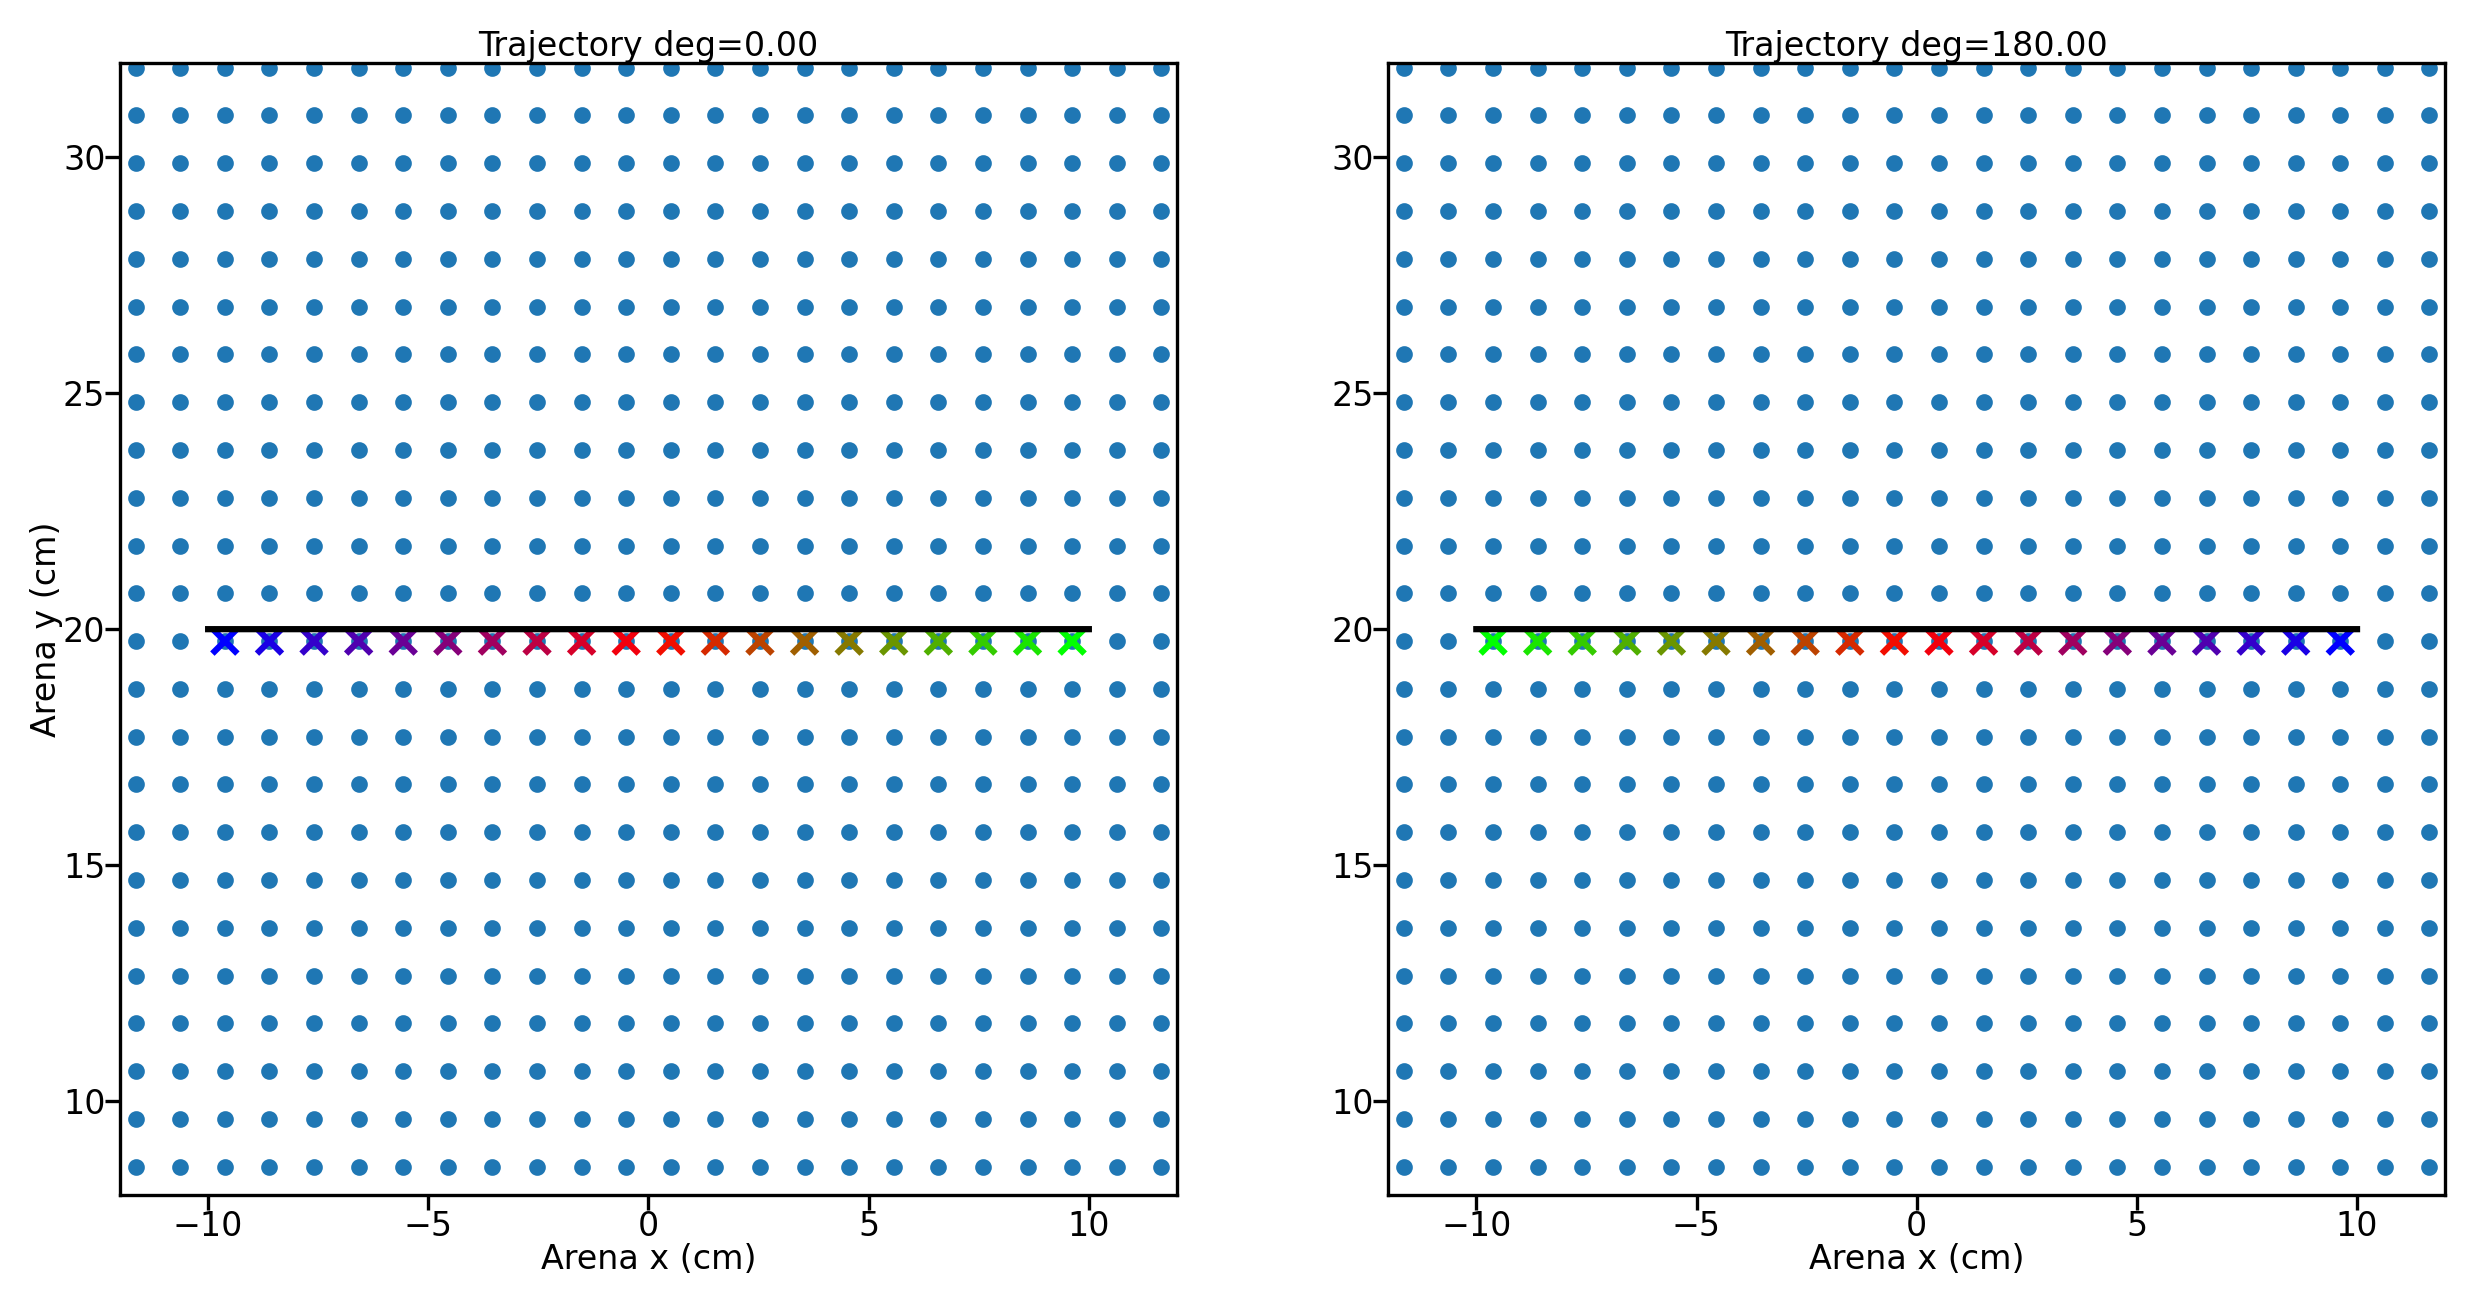

In [5]:
if exintag == 'in':
    yoffset = 20
else:
    yoffset = -20
fig, ax = plt.subplots(1, 2, figsize=(10, 5), facecolor='w', dpi=300)
ax = ax.ravel()
all_nidx = []
for i in range(len(chosen_types)):
    chosen_type = chosen_types[i]

    BehDF_eachtraj = BehDF[BehDF['traj_type'] == chosen_type]
    traj_x_eachtraj = BehDF_eachtraj['traj_x'].to_numpy()
    traj_y_eachtraj = BehDF_eachtraj['traj_y'].to_numpy()
    allnidx_eachtraj = find_nidx_along_traj(traj_x_eachtraj, traj_y_eachtraj, xxtun1d_ca3, yytun1d_ca3)
    allnidx_eachtraj_idx = np.arange(allnidx_eachtraj.shape[0])
    if chosen_type in [3, 9, 15, 21]:
        allnidx_eachtraj = allnidx_eachtraj[(allnidx_eachtraj_idx % 2) == 0]
        allnidx_eachtraj_idx = np.arange(allnidx_eachtraj.shape[0])
    all_nidx.append(allnidx_eachtraj)

    ax[i].plot(traj_x_eachtraj, traj_y_eachtraj, c='k')
    ax[i].scatter(xxtun1d_ca3, yytun1d_ca3, marker='.')
    ax[i].scatter(xxtun1d_ca3[allnidx_eachtraj], yytun1d_ca3[allnidx_eachtraj], c=allnidx_eachtraj_idx, cmap='brg', marker='x')
    ax[i].set_xlim(-12, 12)
    ax[i].set_ylim(-12 + yoffset, +12 + yoffset)
    ax[i].set_title('Trajectory deg=%0.2f'%(np.rad2deg(chosen_type/24*2*np.pi)))

ax[0].set_xlabel('Arena x (cm)')
ax[1].set_xlabel('Arena x (cm)')
ax[0].set_ylabel('Arena y (cm)')
all_nidx = all_nidx[0]



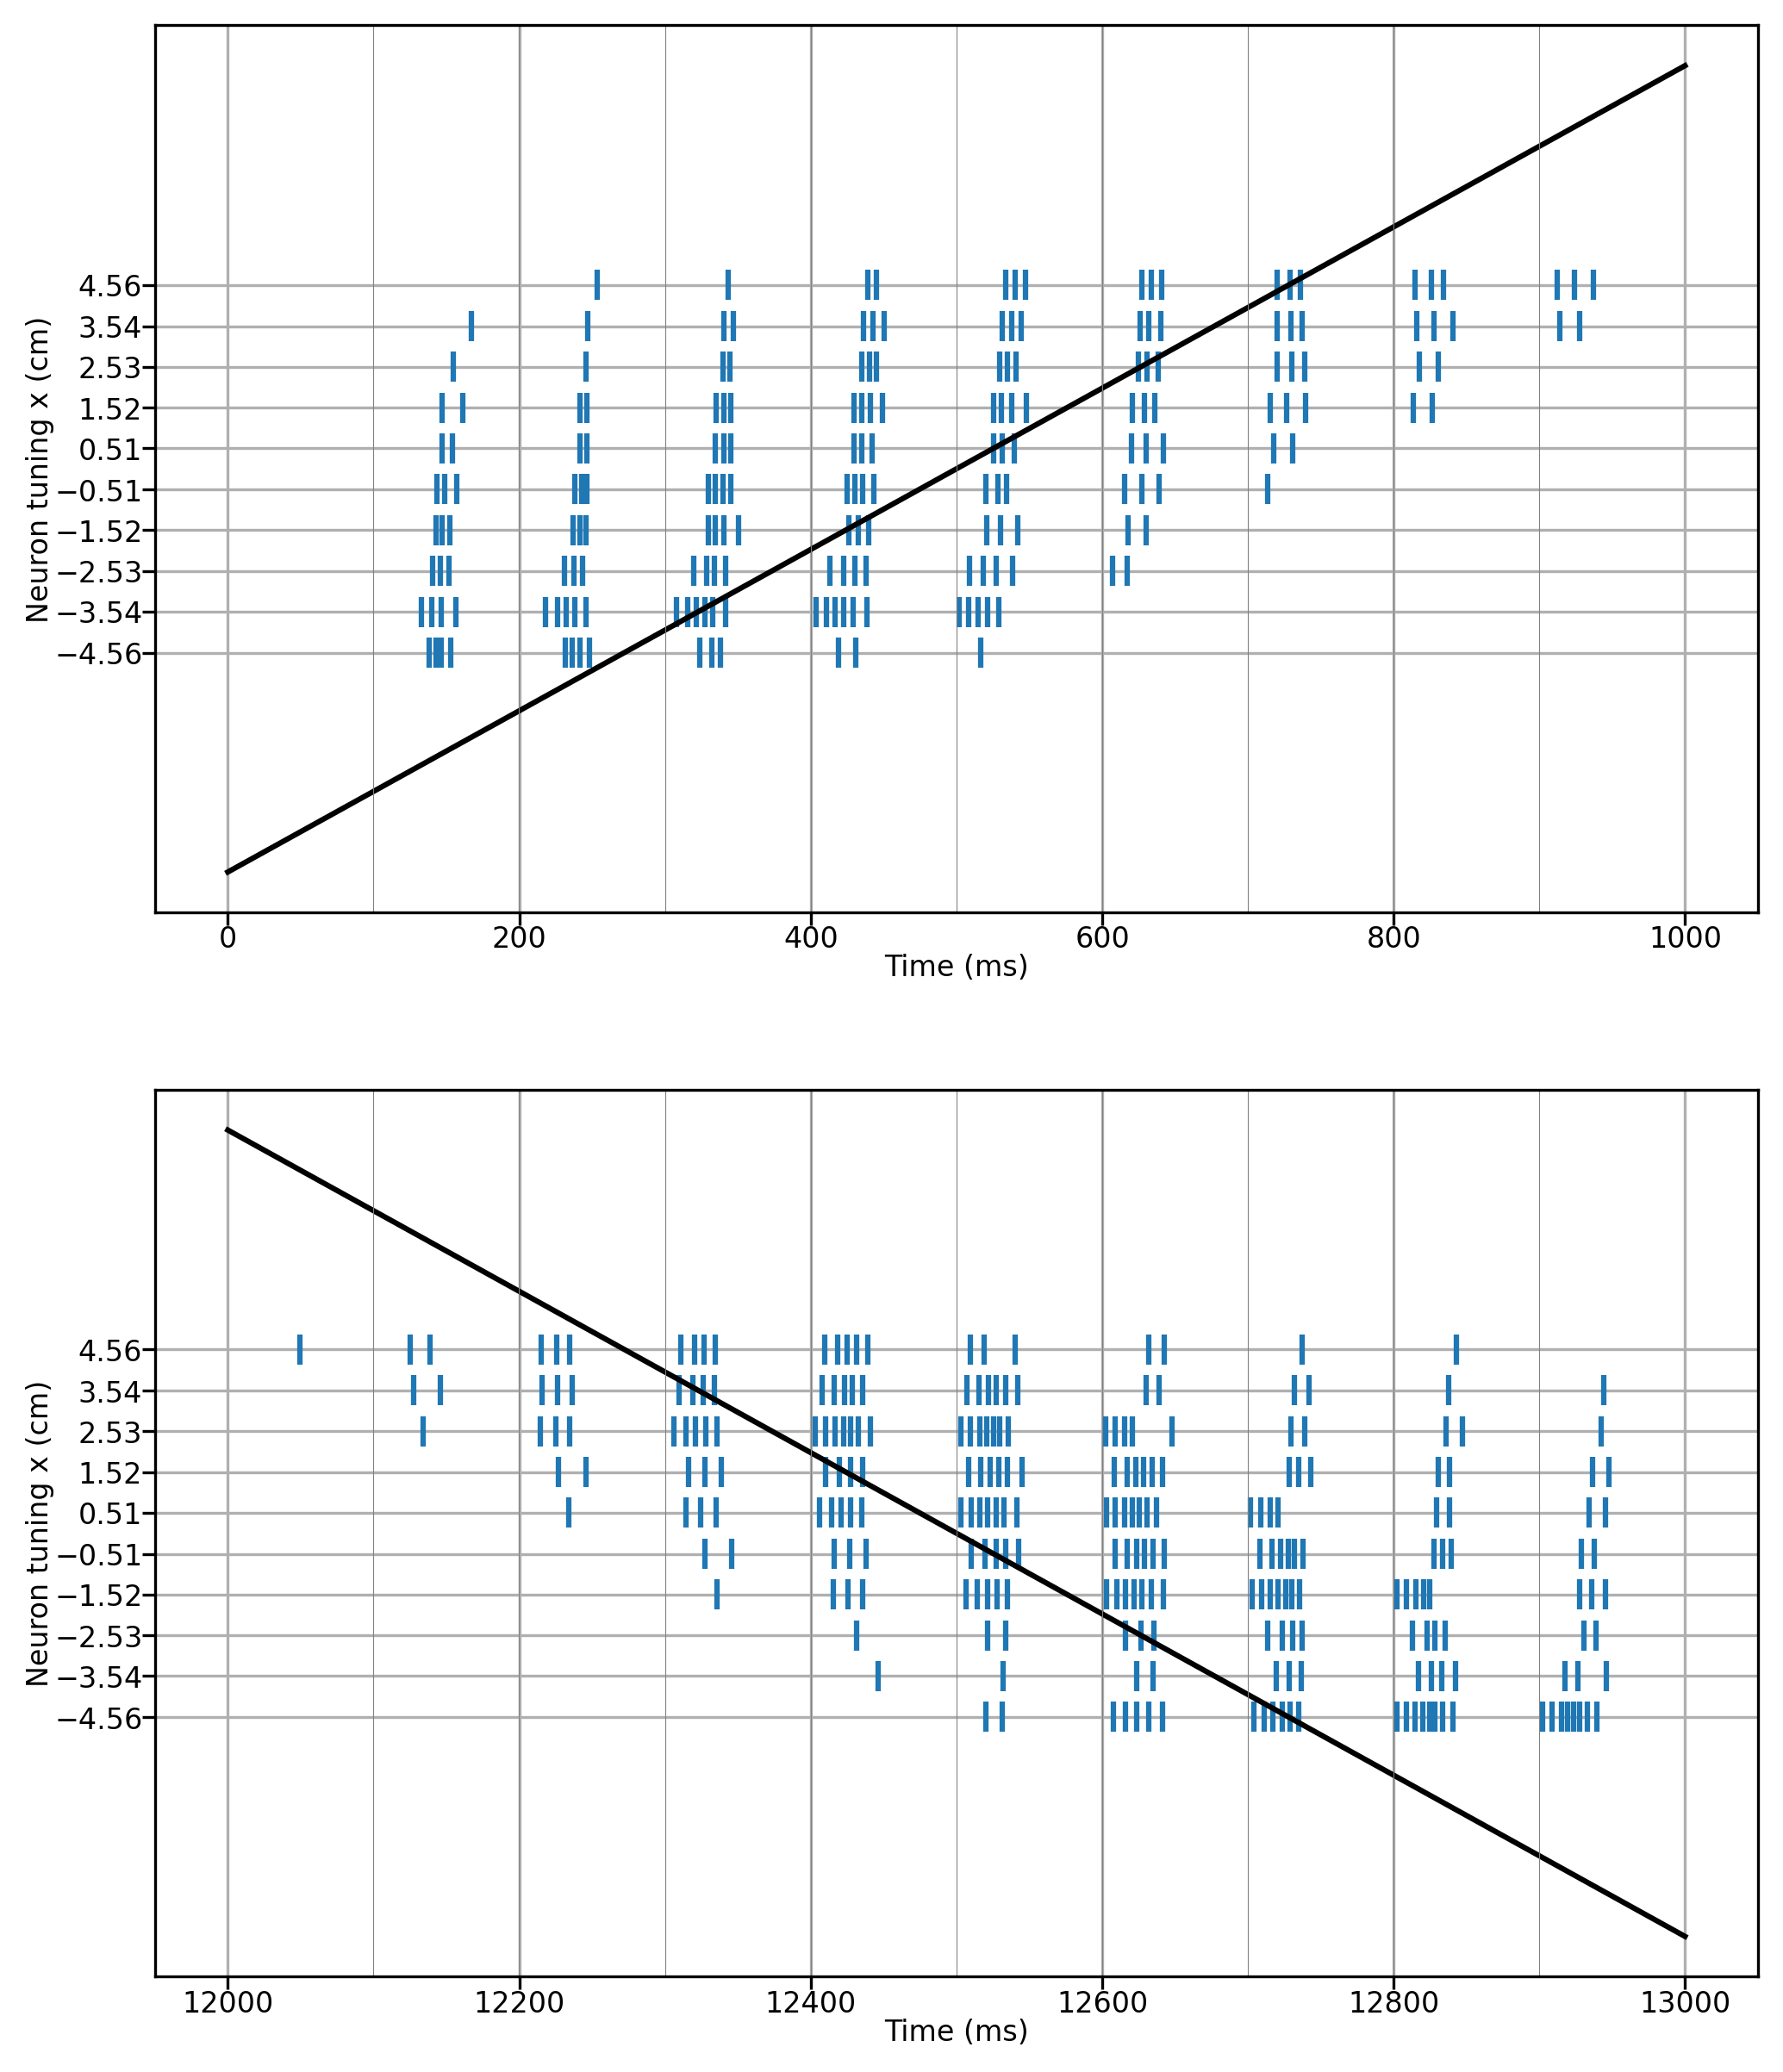

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10), facecolor='w', dpi=300)
for i in range(len(chosen_types)):
    chosen_type = chosen_types[i]

    BehDF_eachtraj = BehDF[BehDF['traj_type'] == chosen_type]
    traj_tindex = BehDF_eachtraj.index
    tidseg_min, tidseg_max = traj_tindex.min(), traj_tindex.max()
    spdf_eachtraj = SpikeDF[(SpikeDF['tidxsp'] > traj_tindex.min()) & (SpikeDF['tidxsp'] <= traj_tindex.max())]

    for nidxi in range(len(all_nidx)):
        nidx = all_nidx[nidxi]
        spdf_MN = spdf_eachtraj[spdf_eachtraj['neuronid'] == nidx]
        tsp = spdf_MN.tsp.to_numpy()
        ax[i].eventplot(tsp, lineoffset=xxtun1d[nidx], linelength=0.75)
    ax[i].plot(BehDF_eachtraj.t, BehDF_eachtraj.traj_x, c='k')

    theta_cutidx = np.where(np.diff(theta_phase_plot[tidseg_min:tidseg_max]) < -6)[0]
    for thetai in theta_cutidx:
        ax[i].axvline(t[tidseg_min:tidseg_max][thetai], c='gray', linewidth=0.25)
        ax[i].axvline(t[tidseg_min:tidseg_max][thetai], c='gray', linewidth=0.25)

    ax[i].set_yticks(np.around(xxtun1d_ca3[all_nidx], 2))
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Neuron tuning x (cm)')
    ax[i].grid()
fig.savefig(join(save_dir, '%s_ras.png'%(exintag)), dpi=300)

Current cycle 9

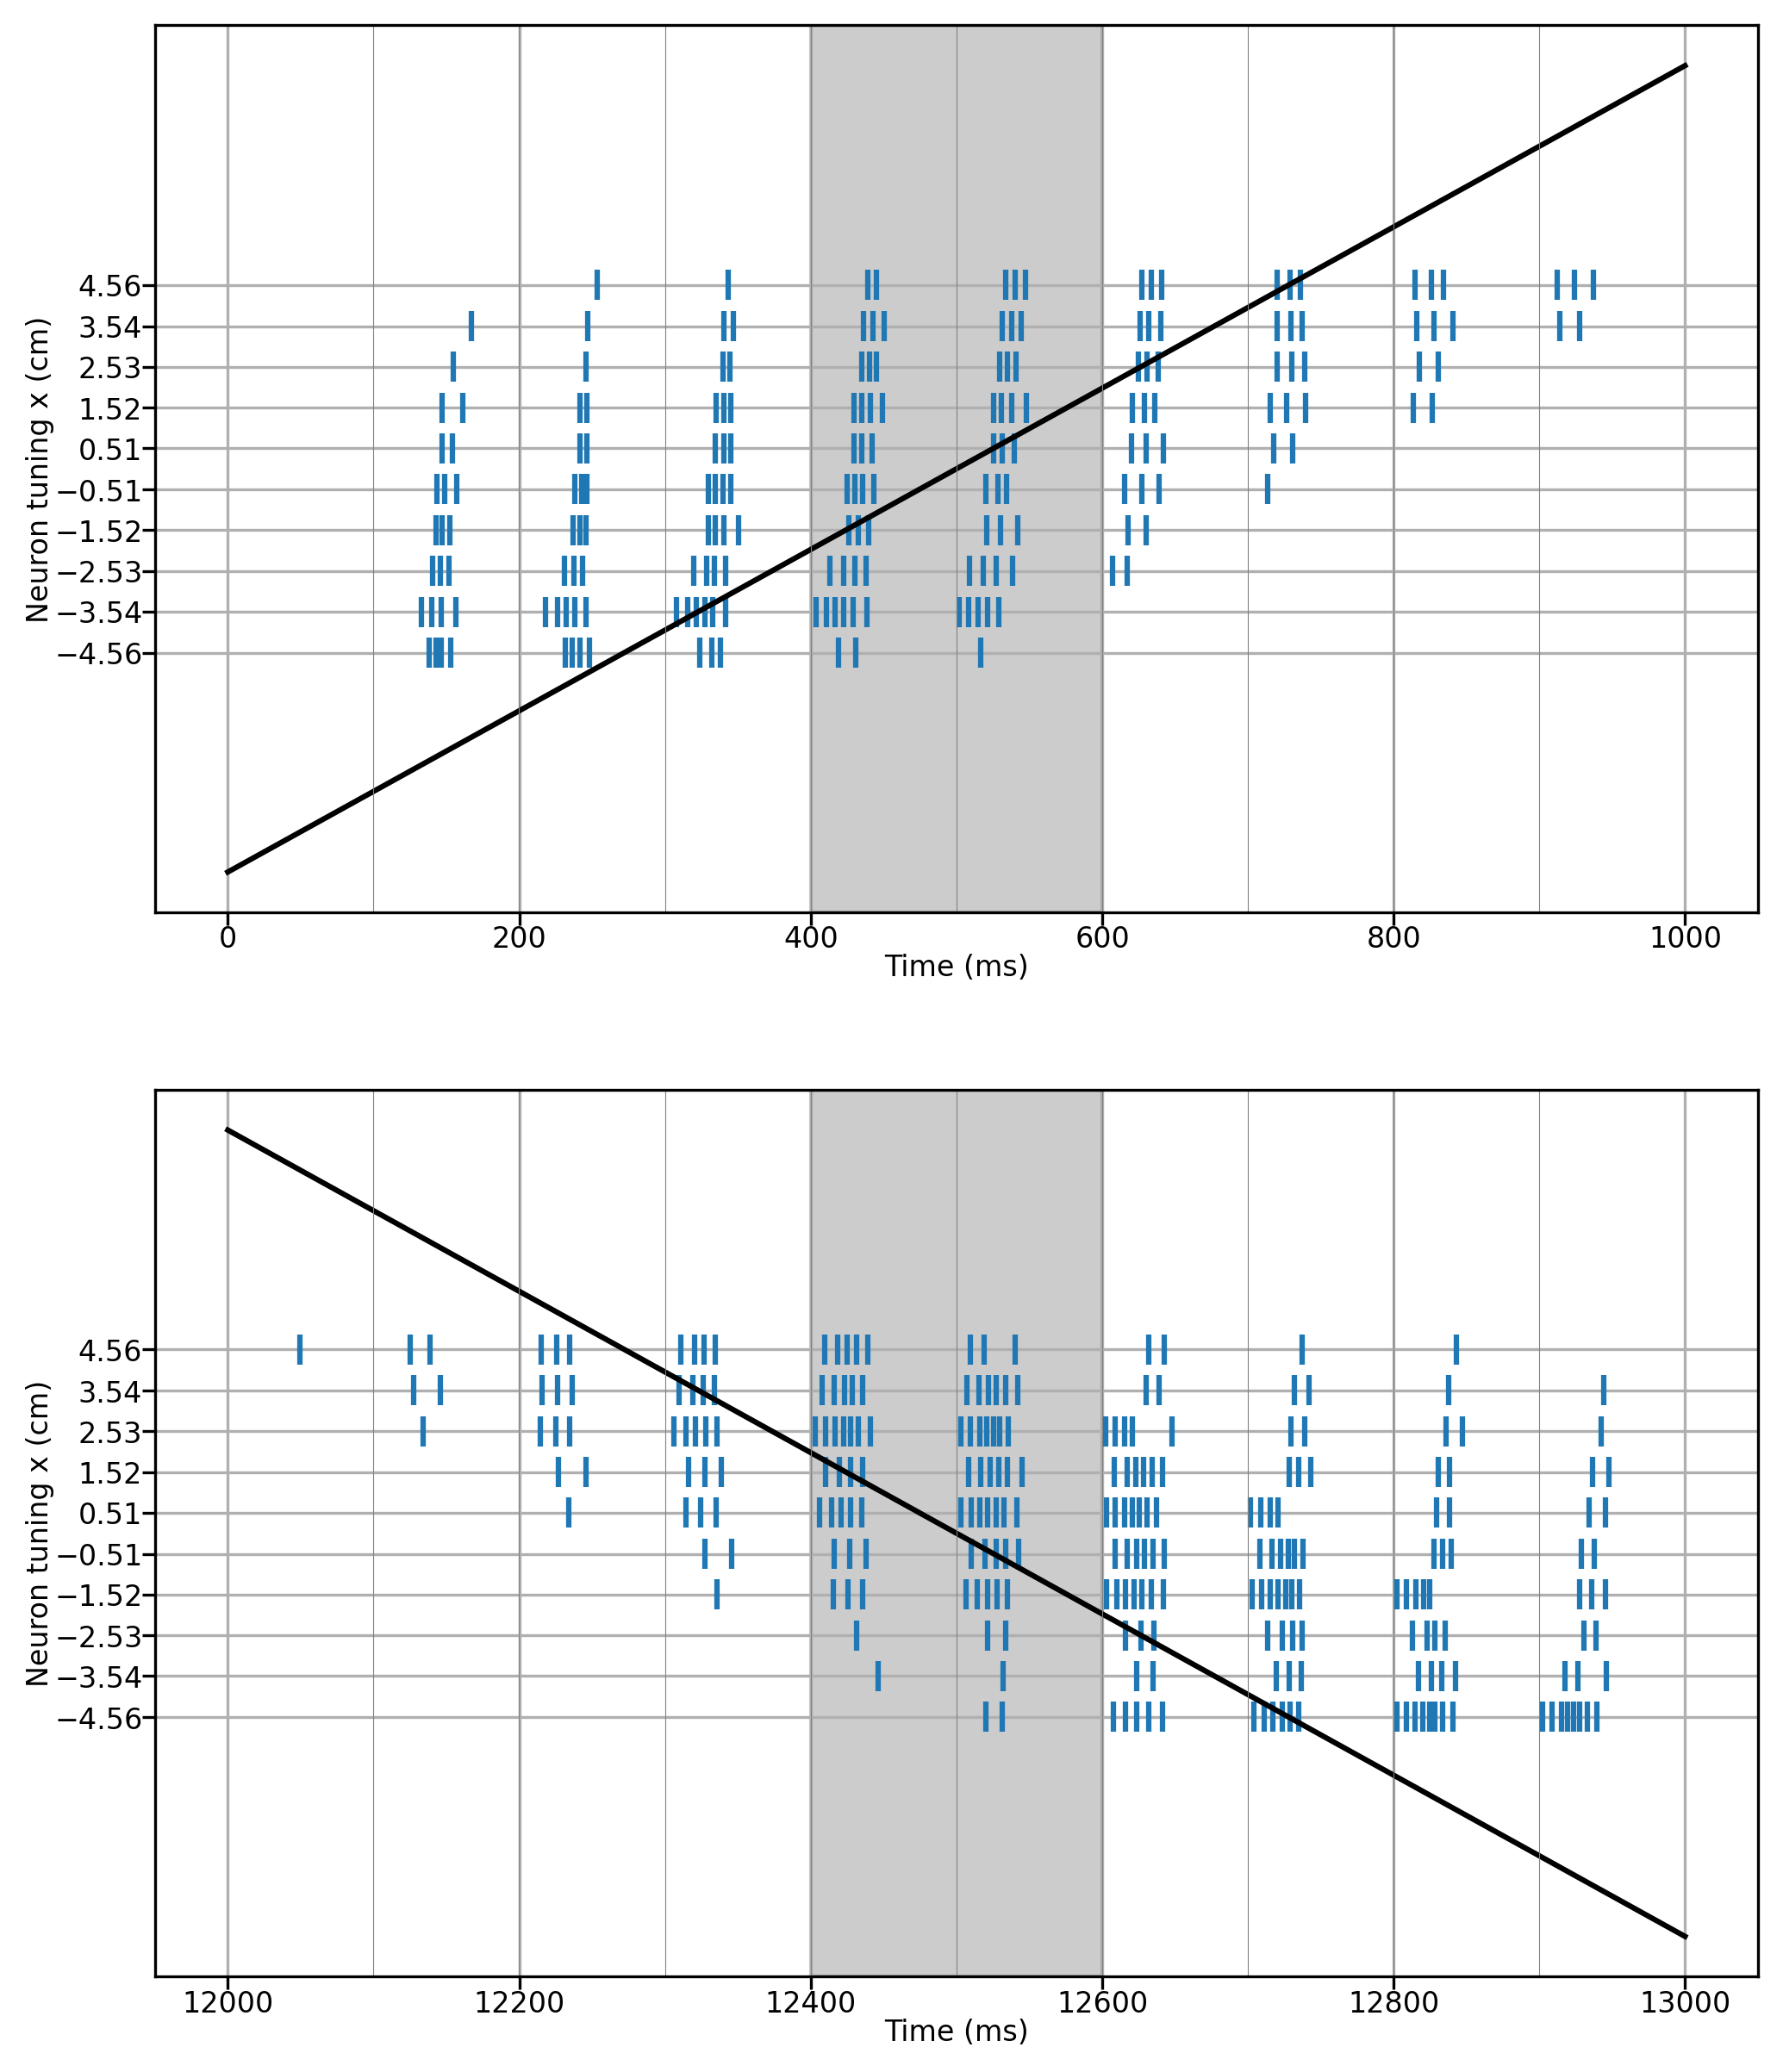

In [7]:
spdftmplist = []
for nidx in all_nidx:
    spdftmplist.append(SpikeDF[SpikeDF['neuronid'] == nidx])
SpikeDF_subset = pd.concat(spdftmplist, ignore_index=True)

data_M = []
label_M = []
trajtype= []
overlap_r = 2
fig, ax = plt.subplots(2, 1, figsize=(8, 10), facecolor='w', dpi=300)

for typei in range(len(chosen_types)):
    chosen_type = chosen_types[typei]
    BehDF_eachtraj = BehDF[BehDF['traj_type'] == chosen_type]
    traj_tindex = BehDF_eachtraj.index
    tidseg_min, tidseg_max = traj_tindex.min(), traj_tindex.max()
    tmin, tmax = BehDF_eachtraj.t.min(), BehDF_eachtraj.t.max()
    cycle_i = 0

    while (tmin + cycle_i * theta_T) < tmax:
        print('\rCurrent cycle %d'%(cycle_i), end='', flush=True)
        theta_tstart = tmin + cycle_i * theta_T
        theta_tend = tmin + (cycle_i + 1) * theta_T
        spdf_M = SpikeDF_subset[(SpikeDF_subset['tsp'] > theta_tstart) & (SpikeDF_subset['tsp'] <= theta_tend)]

        if spdf_M.shape[0] < 1:
            cycle_i += 1
            continue
        data_MN = []
        for nidxi in range(len(all_nidx)):
            nidx = all_nidx[nidxi]
            spdf_MN = spdf_M[spdf_M['neuronid'] == nidx]
            tsp = spdf_MN.tsp.to_numpy()
            if tsp.shape[0] > 1:
                # tsp = np.array([tsp.min()])
                # tsp = np.random.choice(tsp, 1)
                ax[typei].eventplot(tsp, lineoffset=xxtun1d[nidx], linelength=0.75)
            if tsp.shape[0] == 1:
                ax[typei].eventplot(tsp, lineoffset=xxtun1d[nidx], linelength=0.75)

            data_MN.append(tsp - theta_tstart)

        t_intheta = (t > theta_tstart) & (t <= theta_tend)
        # distance to the arena center
        traj_r = np.sqrt((traj_x[t_intheta]-center_x)** 2 + (traj_y[t_intheta]-center_y)** 2)
        r05 = np.median(traj_r)
        if r05 < overlap_r:
            label = True
        else:
            label = False

        data_M.append(data_MN)
        label_M.append(label)
        trajtype.append(chosen_type)
        cycle_i += 1

    ax[typei].plot(BehDF_eachtraj.t, BehDF_eachtraj.traj_x, c='k')
    t_tmp = BehDF_eachtraj['t'][(BehDF_eachtraj.traj_x > -overlap_r) & (BehDF_eachtraj.traj_x <= overlap_r)]
    ax[typei].axvspan(t_tmp.min(), t_tmp.max(), alpha=0.2, color='k')

    theta_cutidx = np.where(np.diff(theta_phase_plot[tidseg_min:tidseg_max]) < -6)[0]
    for thetai in theta_cutidx:
        ax[typei].axvline(t[tidseg_min:tidseg_max][thetai], c='gray', linewidth=0.25)
        ax[typei].axvline(t[tidseg_min:tidseg_max][thetai], c='gray', linewidth=0.25)
    ax[typei].set_yticks(np.around(xxtun1d_ca3[all_nidx], 2))
    ax[typei].set_xlabel('Time (ms)')
    ax[typei].set_ylabel('Neuron tuning x (cm)')
    ax[typei].grid()
fig.savefig(join(save_dir, '%s_ras_1stSpike.png'%(exintag)), dpi=300)

In [8]:
trajtype = np.array(trajtype)
labels = np.array(label_M)
train_idx = np.where(trajtype == 0)[0].astype(int)
test_idx = np.where(trajtype == 12)[0].astype(int)
X_train_ori = [data_M[i] for i in train_idx]
X_test_ori = [data_M[i] for i in test_idx]
Y_train_ori = labels[train_idx]
Y_test_ori = labels[test_idx]
trajtype_train_ori = trajtype[train_idx]
trajtype_test_ori = trajtype[test_idx]

In [9]:
def datagen_jitter(X, Y, trajtype, jitter_num, theta_T, jitter_ms=1):

    M = len(X)
    N = len(X[0])
    new_X = []
    new_Y = []
    new_trajtype = []
    for mi in range(M):

        tsp_Mtmp = np.concatenate(X[mi])
        jitfront, jitend = tsp_Mtmp.min(), theta_T - tsp_Mtmp.max()
        for jitter_i in range(jitter_num):
            new_X_eachM = []
            jit_amount = np.random.uniform(-jitfront, jitend)
            for nj in range(N):
                tsp_ori = X[mi][nj]

                # Jittering
                if tsp_ori.shape[0] > 0:

                    tsp_jittered = tsp_ori + jit_amount + np.random.uniform(-jitter_ms, jitter_ms)
                else:
                    tsp_jittered = tsp_ori
                new_X_eachM.append(tsp_jittered)

            new_X.append(new_X_eachM)
            new_Y.append(Y[mi])
            new_trajtype.append(trajtype[mi])

    return np.array(new_X, dtype=object), np.array(new_Y), np.array(new_trajtype)
jitter_ms = 2.5
X_train, Y_train, trajtype_train = datagen_jitter(X_train_ori, Y_train_ori, trajtype_train_ori, 20, theta_T, jitter_ms=jitter_ms)
X_test, Y_test, trajtype_test = datagen_jitter(X_test_ori, Y_test_ori, trajtype_test_ori, 20, theta_T, jitter_ms=jitter_ms)

print('Training data = %d'%(X_train.shape[0]))
print('True = %d \nFalse = %d'%(Y_train.sum(), Y_train.shape[0]-Y_train.sum()))

print('Testing data = %d'%(X_test.shape[0]))
print('True = %d \nFalse = %d'%(Y_test.sum(), Y_test.shape[0]-Y_test.sum()))

Training data = 180
True = 40 
False = 140
Testing data = 200
True = 40 
False = 160


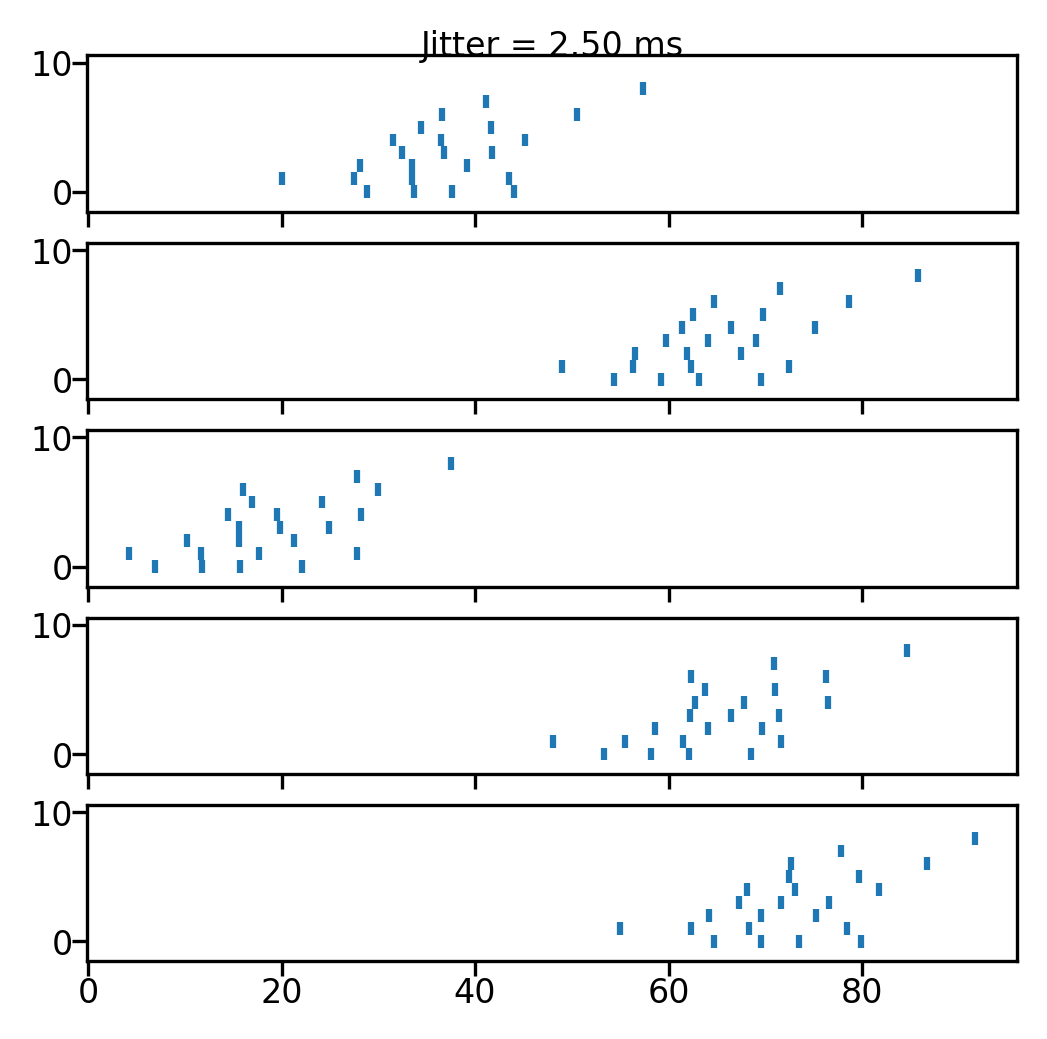

In [10]:
mi = 0
fig, ax = plt.subplots(5, 1, sharex=True, facecolor='w', dpi=300, figsize=(4, 4))
ax[0].set_title('Jitter = %0.2f ms'%jitter_ms)
for ji in range(5):
    _ = ax[ji].eventplot(X_train[mi+ji])
fig.savefig(join(save_dir, '%s_jitter.png'%(exintag)), dpi=300)

In [11]:
num_iter = 500
Vthresh = 2
tau = 5
tau_s = tau/4
w_seed = 0
dt = 0.1
lr = 0.01
temN_tax = np.arange(0, 100, dt)
N = len(data_M[0])

temN = Tempotron(N=N, lr=lr, Vthresh=Vthresh, tau=tau, tau_s=tau_s, w_seed=w_seed)

ACC_train_list, TPR_train_list, TNR_train_list = [], [], []
ACC_test_list, TPR_test_list, TNR_test_list = [], [], []

for trainTMP, testTMP in temN.train(X_train, Y_train, temN_tax, num_iter=num_iter, progress=True, X_test=X_test, Y_test=Y_test):
    (ACC_train, TPR_train, TNR_train), (ACC_test, TPR_test, TNR_test) = trainTMP, testTMP
    ACC_train_list.append(ACC_train)
    TPR_train_list.append(TPR_train)
    TNR_train_list.append(TNR_train)
    ACC_test_list.append(ACC_test)
    TPR_test_list.append(TPR_test)
    TNR_test_list.append(TNR_test)

 Iter 168/500: Correct trials 180/180 = 1.000

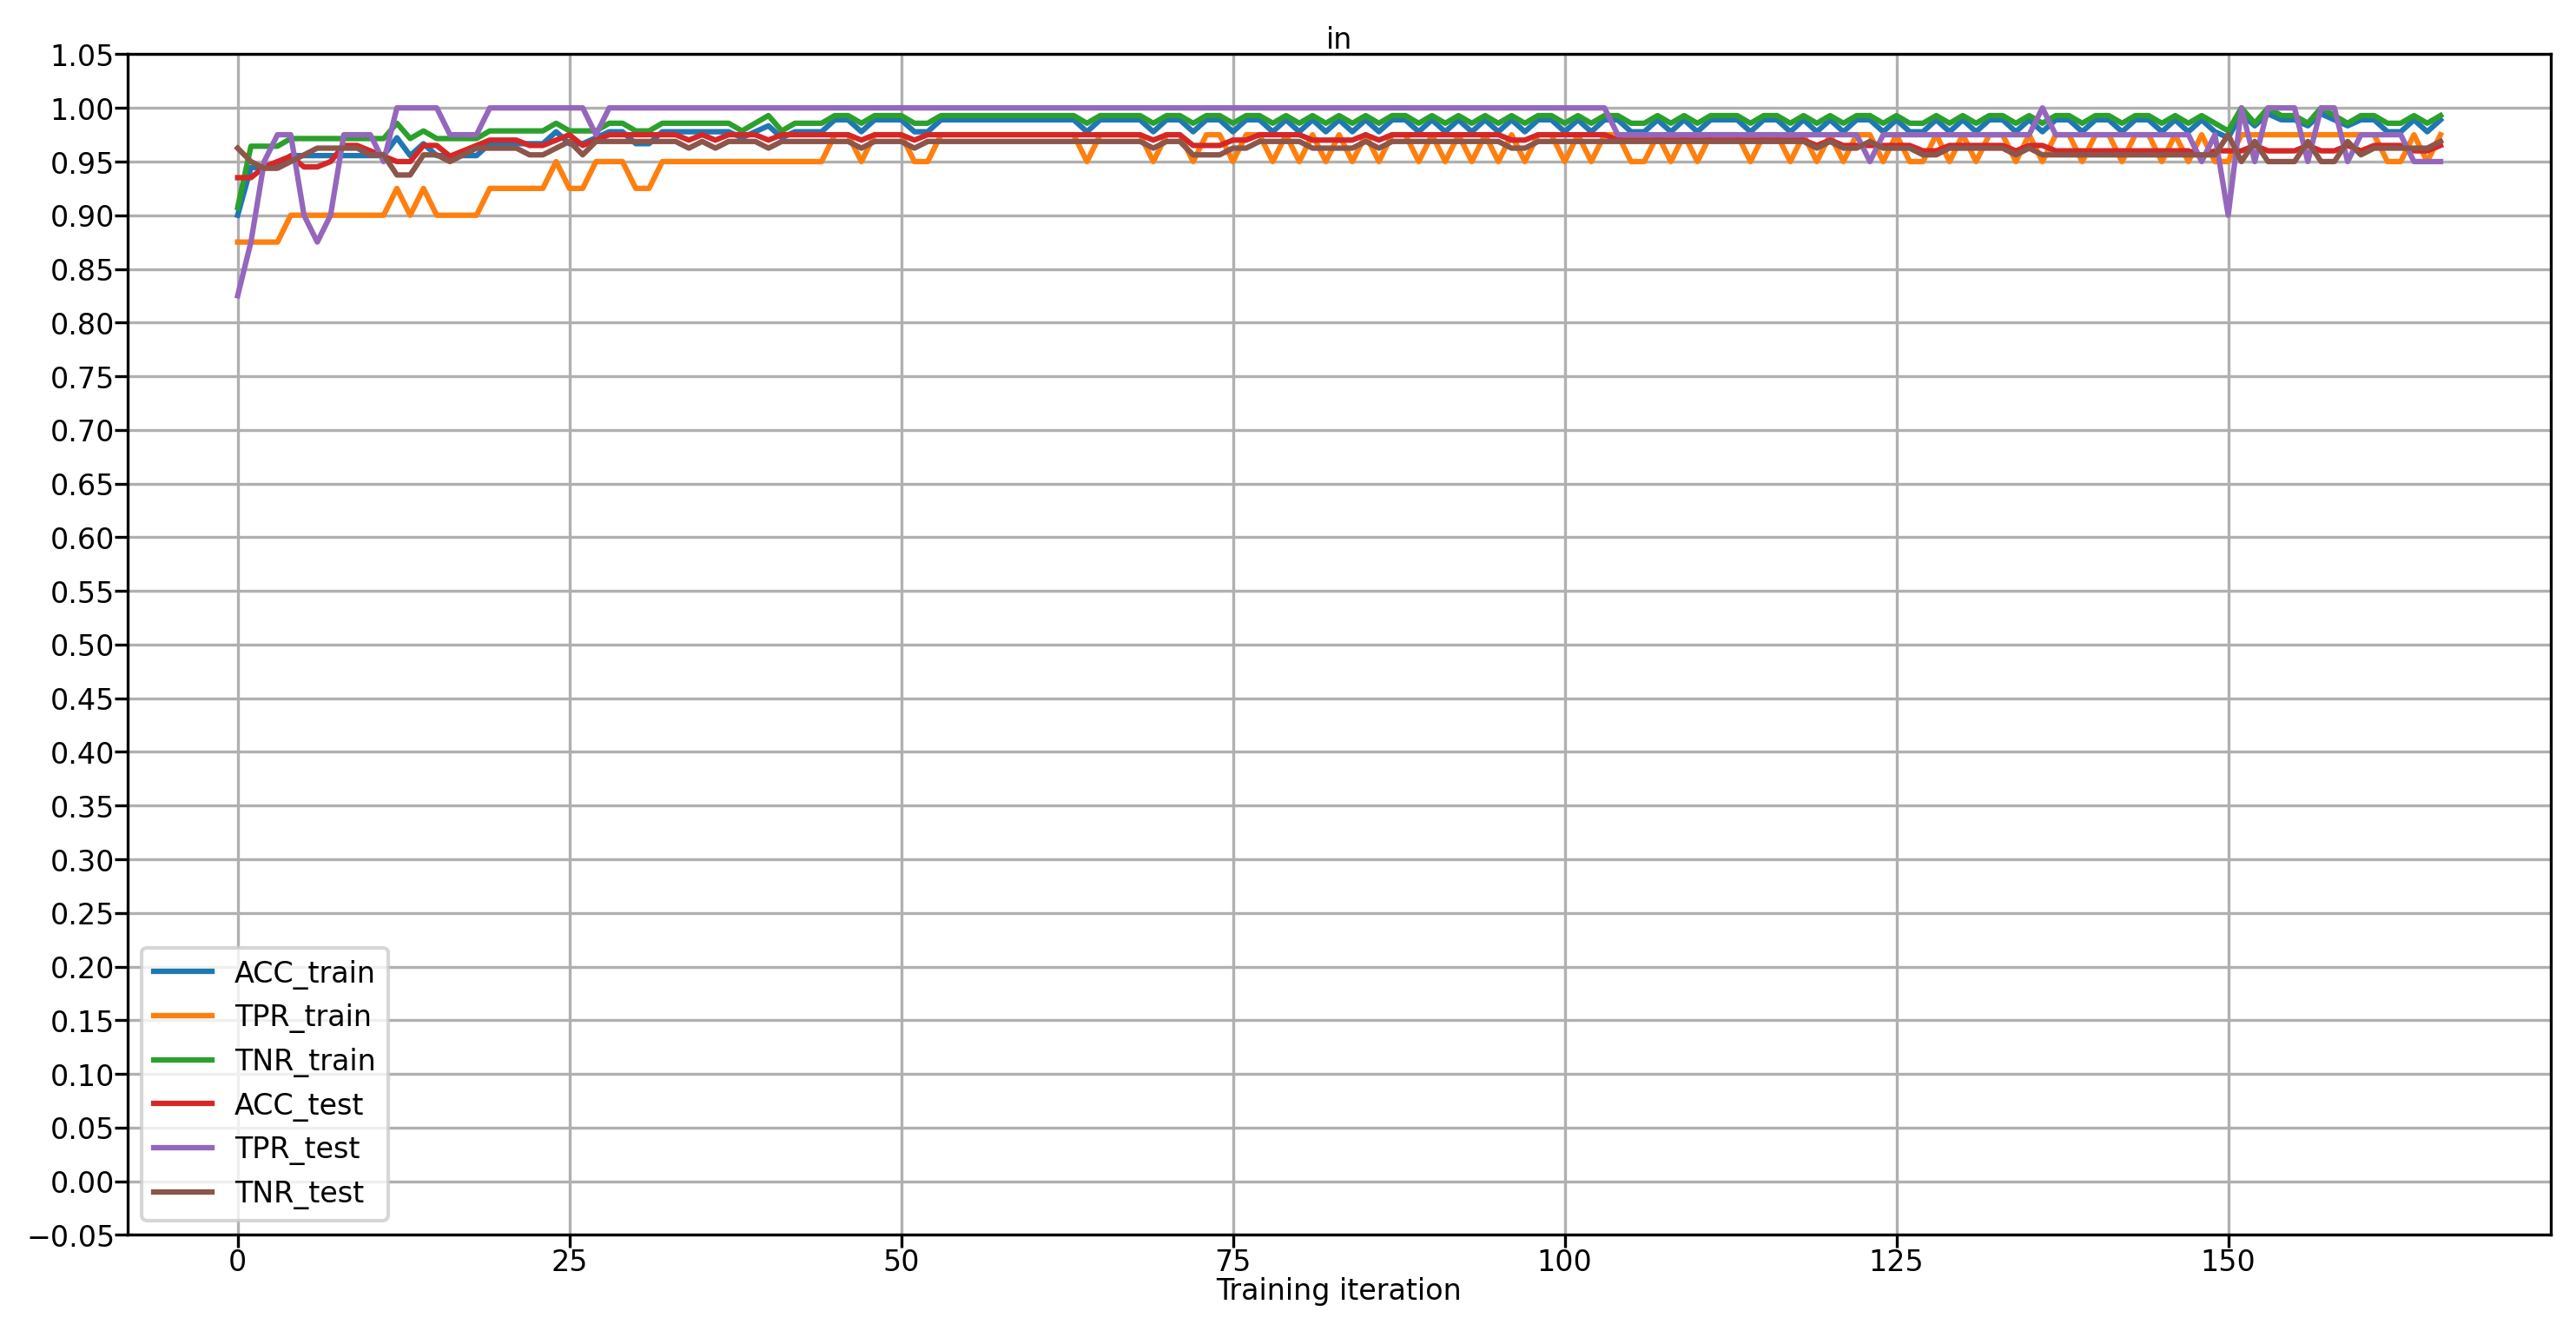

In [12]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300, facecolor='w')
ax.plot(ACC_train_list, label='ACC_train')
ax.plot(TPR_train_list, label='TPR_train')
ax.plot(TNR_train_list, label='TNR_train')
ax.plot(ACC_test_list, label='ACC_test')
ax.plot(TPR_test_list, label='TPR_test')
ax.plot(TNR_test_list, label='TNR_test')
# ax.set_ylim(-0.05, 1.05)
ax.set_yticks(np.arange(-0.05, 1.1, 0.05))
# ax.set_yticks(np.arange(0, 1, 0.05), minor=True)
ax.grid()
ax.set_xlabel('Training iteration')
ax.set_title('%s'%(exintag))
ax.legend()
fig.savefig(join(save_dir, '%s_training.png'%(exintag)), dpi=300)

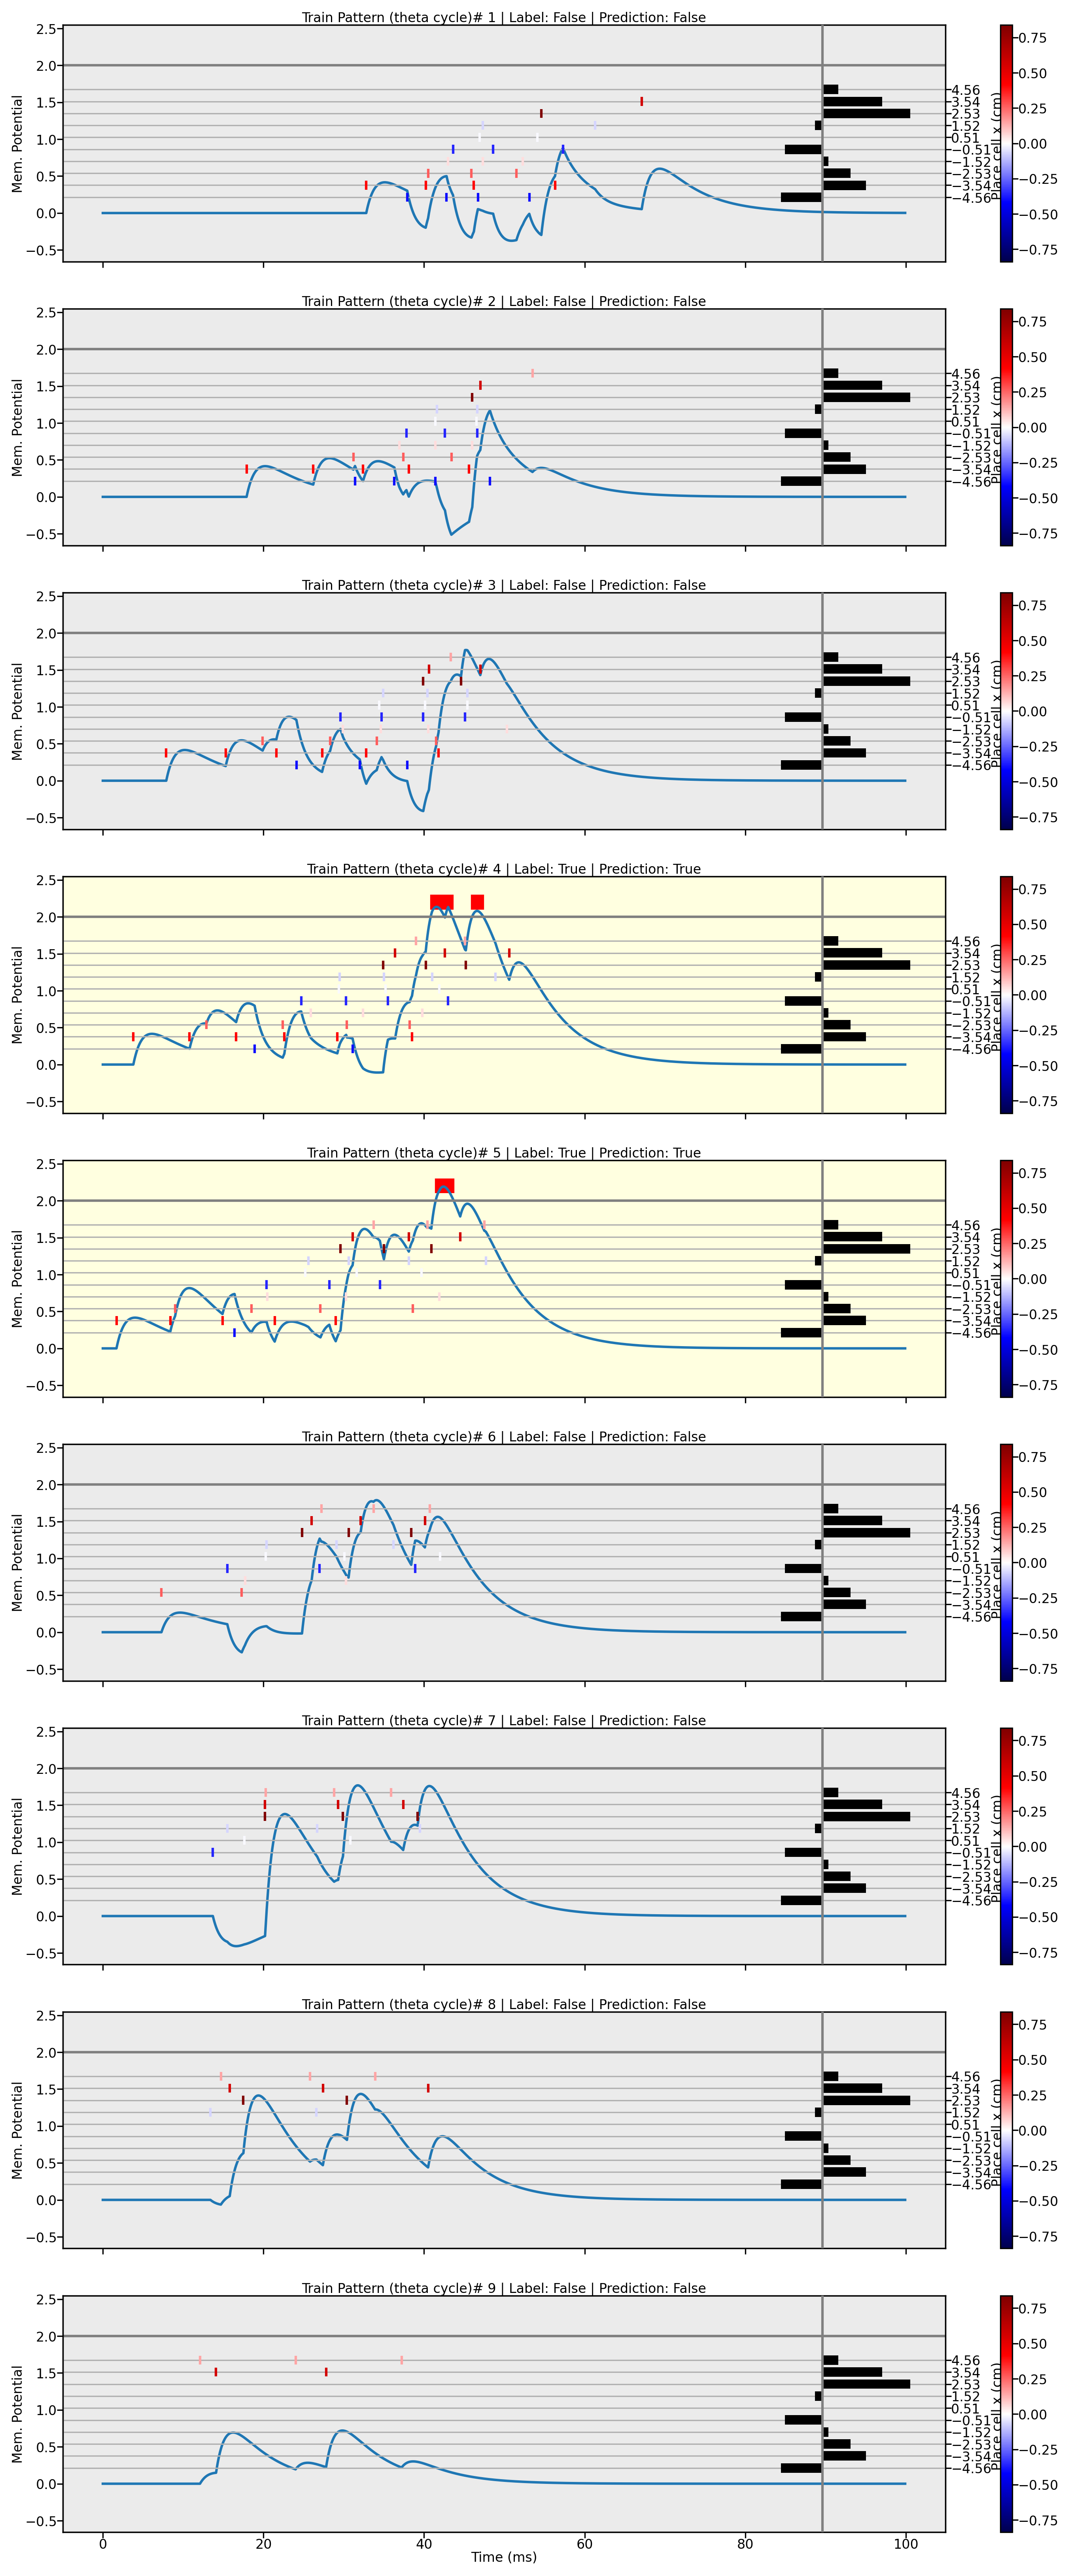

In [13]:
import matplotlib as mpl
import matplotlib.cm as cm
wmin, wmax = temN.w.min(), temN.w.max()
abswmax = max(np.abs(wmin), np.abs(wmax))
norm = mpl.colors.Normalize(vmin=-abswmax, vmax=abswmax)
val2cmap = cm.ScalarMappable(norm=norm, cmap=cm.seismic)


Y_pred_train_ori, kout_train_ori_list, tspout_train_ori_list, _ = temN.predict(X_train_ori, temN_tax)

see_X = X_train_ori
see_Y = Y_train_ori
see_Y_pred = Y_pred_train_ori
see_tspout = tspout_train_ori_list
see_kout = kout_train_ori_list


fig, ax = plt.subplots(len(see_kout), 1, sharex=True, sharey=True, figsize=(12, 28), facecolor='white', dpi=300)
for i in range(len(see_kout)):
    ax[i].plot(temN_tax, see_kout[i])
    ax[i].axhline(Vthresh, color='gray')
    if see_Y[i]:
        ax[i].set_facecolor('lightyellow')
    else:
        ax[i].set_facecolor('0.92')

    ax_sp = ax[i].twinx()
    for nj in range(N):
        ax_sp.eventplot(see_X[i][nj], lineoffset=xxtun1d[all_nidx[nj]], linelength=0.75, color=val2cmap.to_rgba(temN.w[nj]))
    ax_sp.set_ylim(-10, 10)
    ax_sp.set_yticks(np.around(xxtun1d[all_nidx], 2))
    ax_sp.set_ylabel('Place cell x (cm) ')
    ax_sp.grid()
    ax[i].eventplot(see_tspout[i], lineoffsets=2.2, linelengths=0.2, color='r')
    ax[i].set_title('Train Pattern (theta cycle)# %d | Label: %s | Prediction: %s' %(i+1, see_Y[i], see_Y_pred[i]))
    ax[i].set_ylabel('Mem. Potential')

    left, bottom, width, height = ax[i].get_position().bounds
    ax_w = fig.add_axes([left+0.5, bottom, 0.1, height])
    ax_w.barh(xxtun1d[all_nidx], temN.w, color='k')
    ax_w.axvline(0, color='gray')
    ax_w.set_yticks(np.around(xxtun1d[all_nidx], 2))
    ax_w.axis('off')
    ax_w.set_ylim(-10, 10)

    plt.colorbar(val2cmap, ax=ax[i])
ax[i].set_xlabel('Time (ms)')
fig.savefig(join(save_dir, '%s_train_trace.png'%(exintag)), dpi=300)


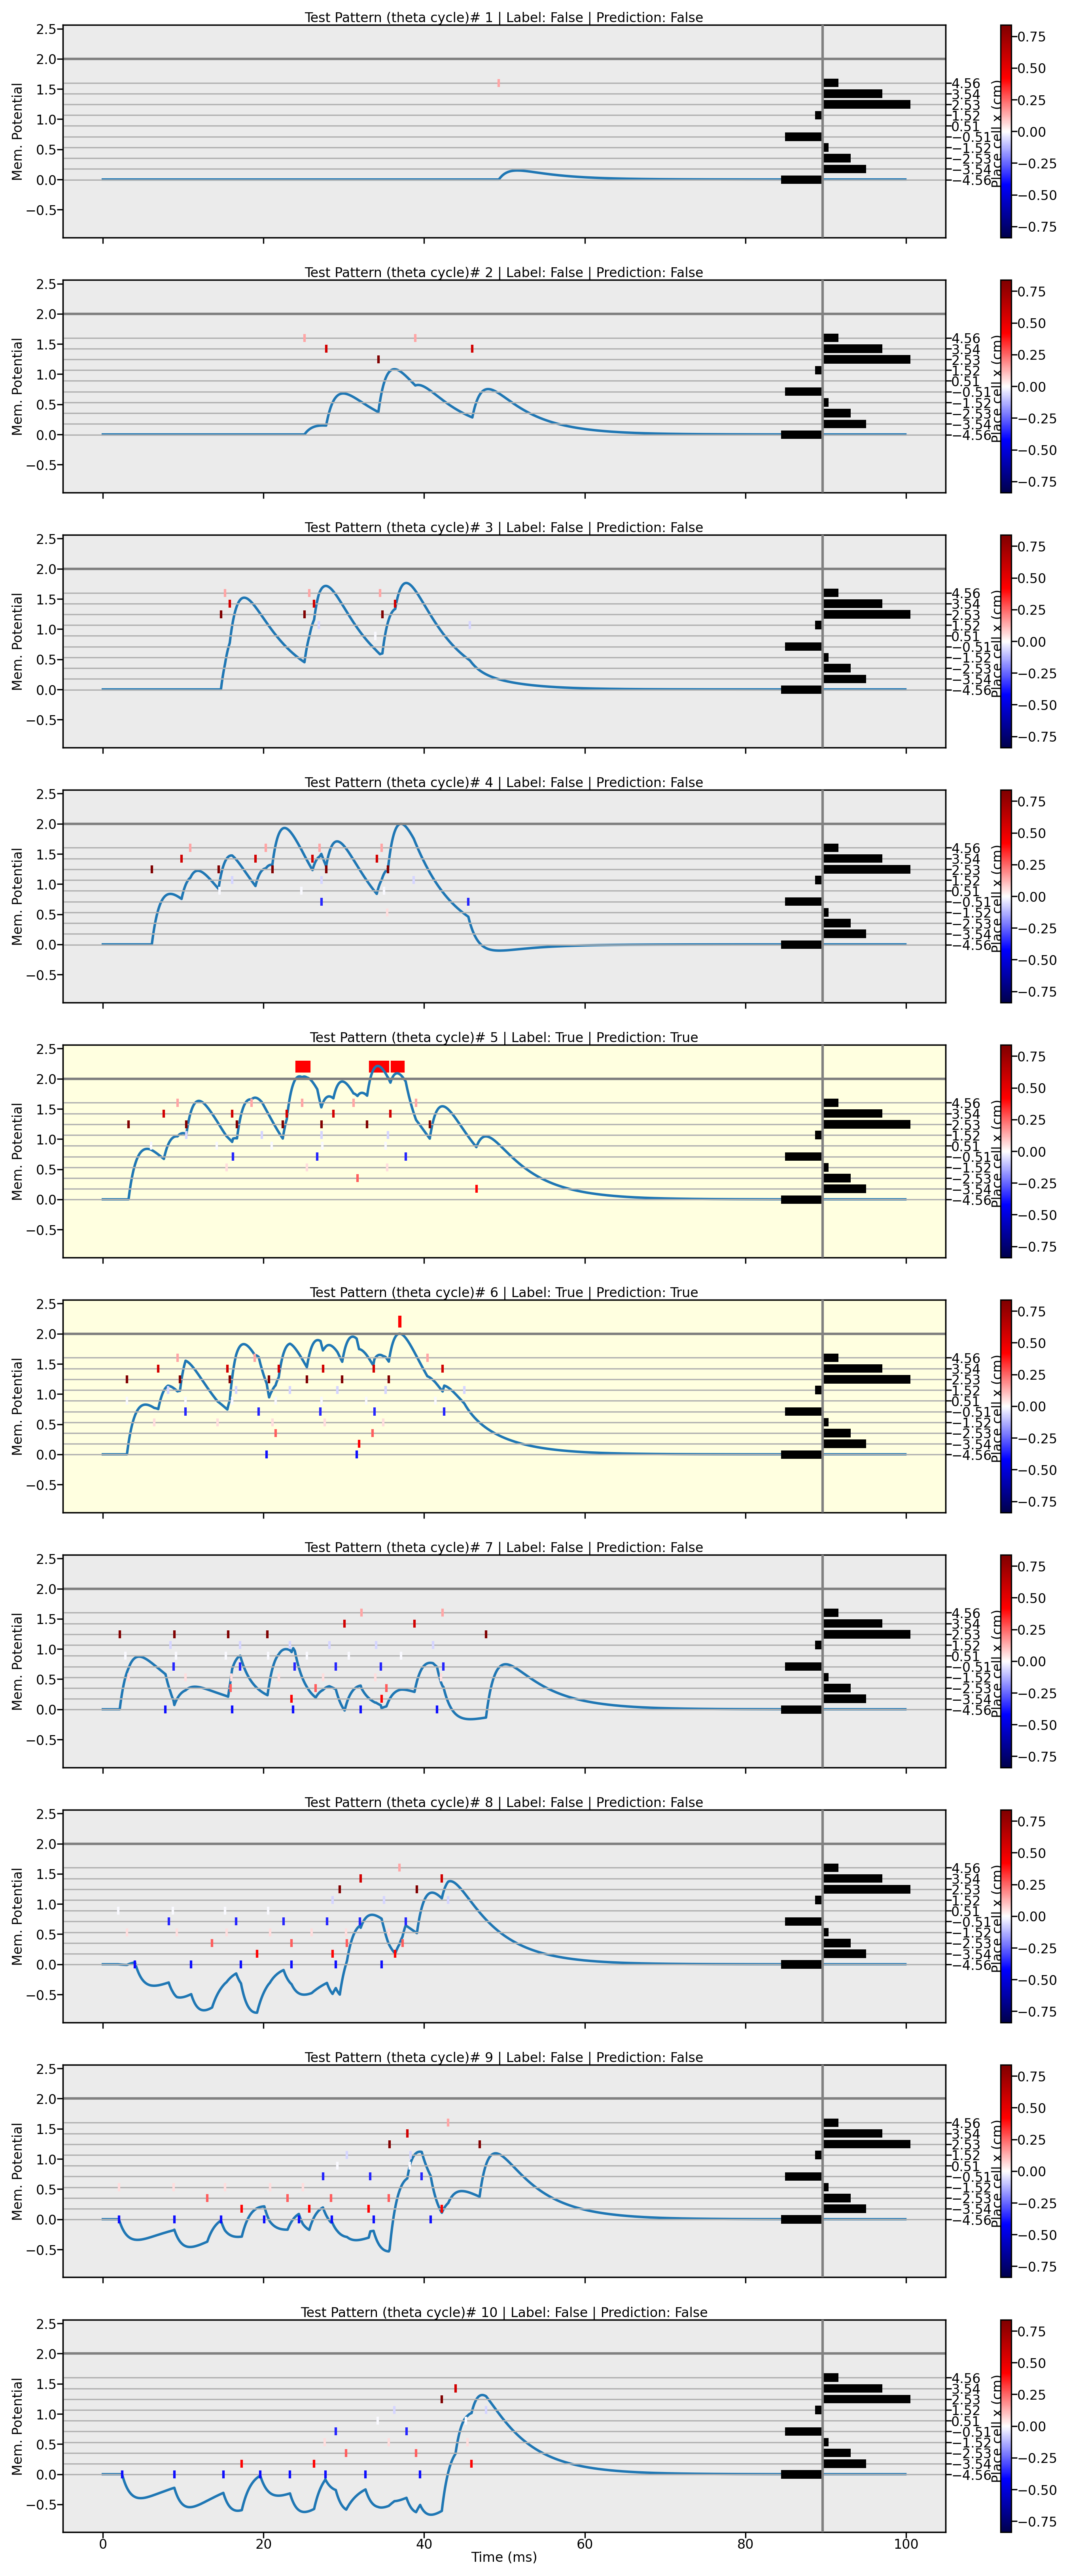

In [14]:
Y_pred_test_ori, kout_test_ori_list, tspout_test_ori_list, _ = temN.predict(X_test_ori, temN_tax)

see_X = X_test_ori
see_Y = Y_test_ori
see_Y_pred = Y_pred_test_ori
see_tspout = tspout_test_ori_list
see_kout = kout_test_ori_list


fig, ax = plt.subplots(len(see_kout), 1, sharex=True, sharey=True, figsize=(12, 28), facecolor='white', dpi=300)
for i in range(len(see_kout)):
    ax[i].plot(temN_tax, see_kout[i])
    ax[i].axhline(Vthresh, color='gray')
    if see_Y[i]:
        ax[i].set_facecolor('lightyellow')
    else:
        ax[i].set_facecolor('0.92')
    ax_sp = ax[i].twinx()
    for nj in range(N):
        ax_sp.eventplot(see_X[i][nj], lineoffset=xxtun1d[all_nidx[nj]], linelength=0.75, color=val2cmap.to_rgba(temN.w[nj]))
    ax_sp.set_ylim(-10, 10)
    ax_sp.set_yticks(np.around(xxtun1d[all_nidx], 2))
    ax_sp.set_ylabel('Place cell x (cm) ')
    ax_sp.grid()
    ax[i].eventplot(see_tspout[i], lineoffsets=2.2, linelengths=0.2, color='r')
    ax[i].set_title('Test Pattern (theta cycle)# %d | Label: %s | Prediction: %s' %(i+1, see_Y[i], see_Y_pred[i]))
    ax[i].set_ylabel('Mem. Potential')

    left, bottom, width, height = ax[i].get_position().bounds
    ax_w = fig.add_axes([left+0.5, bottom, 0.1, height])
    ax_w.barh(xxtun1d[all_nidx], temN.w, color='k')
    ax_w.axvline(0, color='gray')
    ax_w.set_yticks(np.around(xxtun1d[all_nidx], 2))
    ax_w.axis('off')
    ax_w.set_ylim(-10, 10)

    plt.colorbar(val2cmap, ax=ax[i])
ax[i].set_xlabel('Time (ms)')
fig.savefig(join(save_dir, '%s_test_trace.png'%(exintag)), dpi=300)

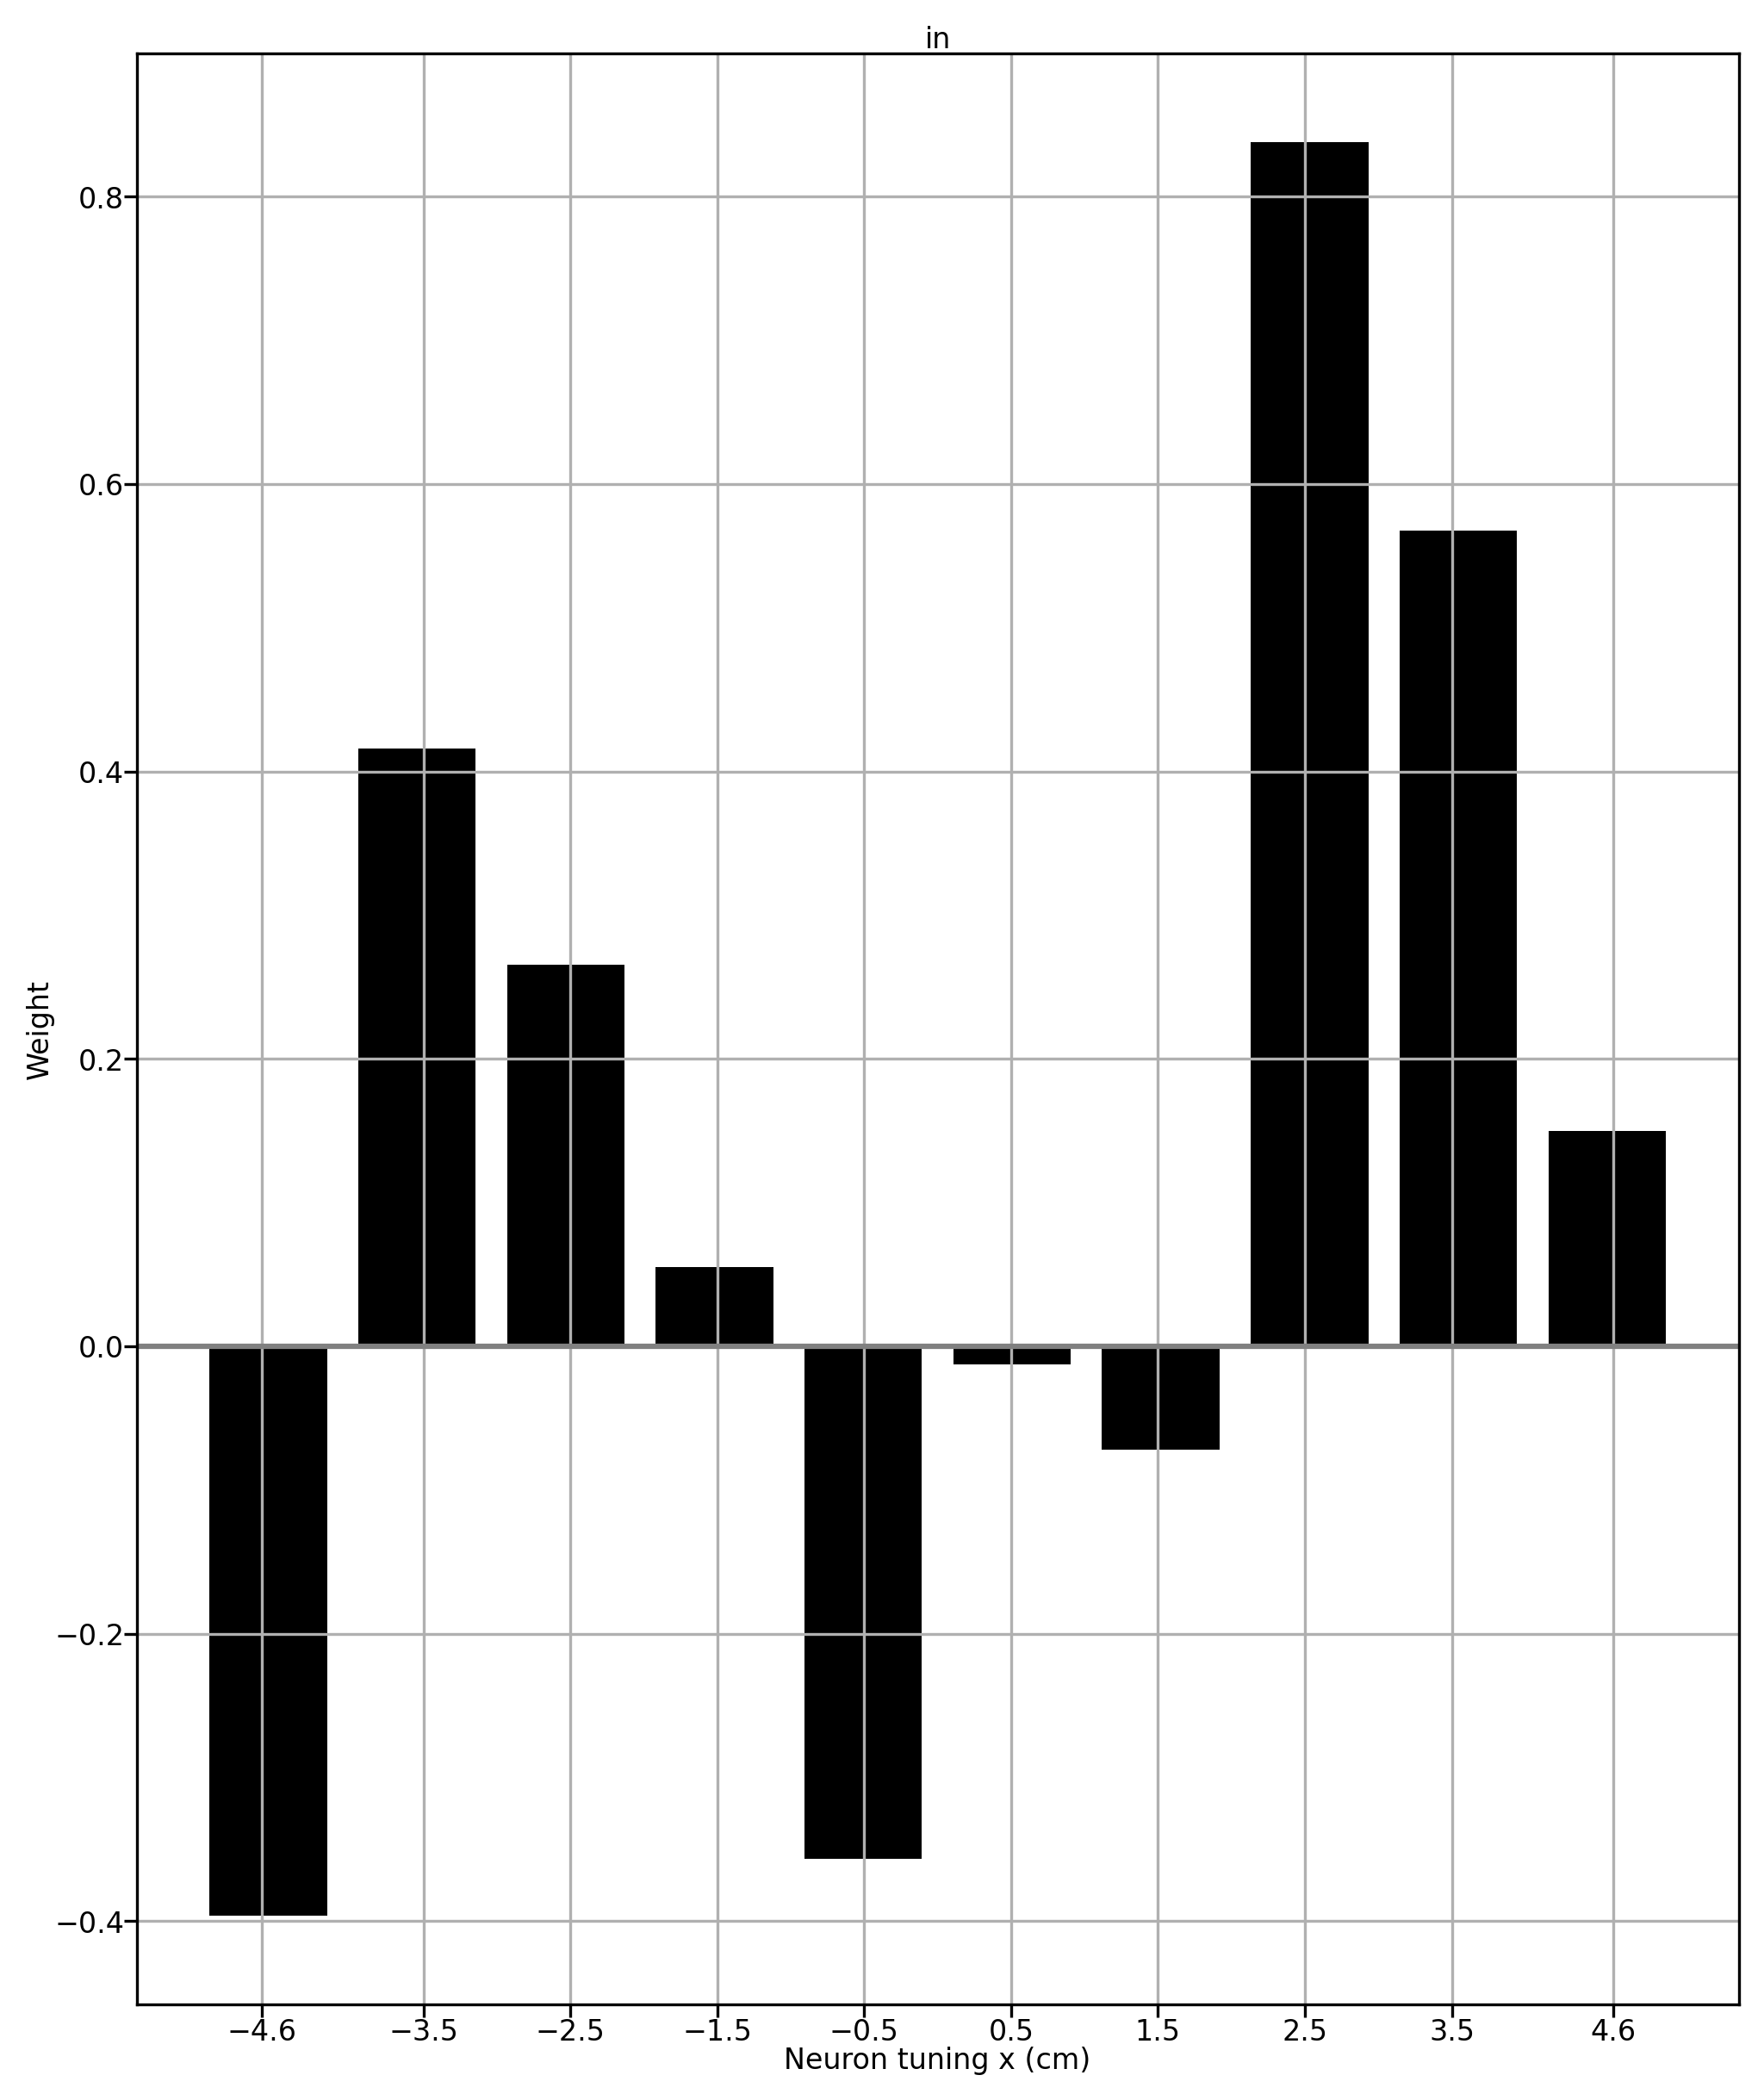

In [15]:
fig, ax = plt.subplots(figsize=(8, 10), facecolor='w', dpi=300)
ax.axhline(0, color='gray')
ax.bar(xxtun1d[all_nidx], temN.w, color='k')
ax.set_xlabel('Neuron tuning x (cm)')
ax.set_ylabel('Weight')
_ = ax.set_xticks(np.around(xxtun1d[all_nidx], 1))
_ = ax.set_title(exintag)
ax.grid()
fig.savefig(join(save_dir, '%s_weights.png'%(exintag)), dpi=300)
